# Daten einlesen
(In der Datei sind einige Variablen doppelt belegt. Damit wir nicht immer wieder die gleiche Warnung angezeigt bekommen, unterdrücken wir diese hier ausnahmsweise mit der `filterwarnings`-Funktion.)

In [1]:
import warnings
import scipy.io

warnings.filterwarnings('ignore')
data = scipy.io.loadmat('Outputdaten_FLP_V11_4.mat')

# Datumsformat konvertieren
MATLAB verwendet ein proprietäres Format zur Darstellung von Daten (vergangene Tage seit 1. Januar 0000).  
Um sinnvoll damit arbeiten zu können, wandeln wir das in ein Standardformat um.

In [2]:
import datetime

def matlab2datetime(matlab_datenum):
    day = datetime.datetime.fromordinal(int(matlab_datenum))
    dayfrac = datetime.timedelta(days = matlab_datenum % 1) - datetime.timedelta(days = 366)
    return day + dayfrac

my_times=[]
for i in range(data["dev_time_num"].size):
    my_times.append(matlab2datetime(data["dev_time_num"][i][0]))

# Definitionen und Funktionen
Hier definieren wir ein paar Konstanten und eine Funktion, um die Diagramme des ausgewählten Containers darzustellen.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.dates as mdates
import numpy as np

# Spalten in Diagrammen
appenzellerholz = 0
holzrahmenbau   = 1
massivbau       = 2

cm = 1/2.54  # centimeters in inches

def plot_u_values(container, title):
    # diagram ratio: 25/41
    fig, axs = plt.subplots(3, 1, figsize=(41*cm, 75*cm))
    axs = axs.flatten()

    # data rows that are used several times
    s_sys    = data["U_Av_s_sys"][:, container]
    s_ges    = data["U_Av_s_ges"][:, container]
    c_s_ges  = data["U_ISO_Av_C_s_ges"][:, container]
    av_s_sys = data["U_ISO_Av_s_sys"][:, container]
    
    # plot mean values
    axs[0].plot(my_times, data["U_Av"][:, container], label="Mittelwert",    color='black', linestyle='none', marker=".", markersize=1)
    axs[0].plot(my_times, s_sys,                      label="sys Fehler MW", color='red',   linestyle='solid')
    axs[0].plot(my_times, s_ges,                      label="ges Fehler MW", color='blue',  linestyle='solid')
    axs[0].set_ylabel(r"Wärmedurchgangskoeffizient in $\frac{W}{m^2 \cdot K}$")
    axs[0].yaxis.set_major_locator(MultipleLocator(0.05))
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(0.01))

    # plot observational errors
    meanError = np.nanmean(s_sys)
    squareMeanError = np.sqrt(np.nansum(np.square(s_sys))) / (len(s_sys) - np.count_nonzero(np.isnan(s_sys)))
    standardDeviation = np.nanstd(s_sys)
    axs[1].plot(my_times,     s_sys,                         label="sys Fehler MW",   color='red',   linestyle='solid')
    axs[1].plot(my_times,     s_ges,                         label="ges Fehler MW",   color='blue',  linestyle='solid')
    axs[1].plot(my_times,     data["U_s_sys"][:, container], label="Messfehler",      color='lime',  linestyle='none', marker=".", markersize=1)
    axs[1].plot(my_times[-1], meanError,                     label="Mean Messfehler", color='black', linestyle='none', marker="*", markersize=10)
    axs[1].plot(my_times[-1], standardDeviation,             label="SD Messfehler",   color='black', linestyle='none', marker="o", markersize=10, fillstyle="none")
    axs[1].set_ylabel(r"Fehler Wärmedurchgangskoeffizient in $\frac{W}{m^2 \cdot K}$")
    
    # plot even more errors
    axs[2].plot(my_times, s_ges,                                        label="MW ges Fehler",     color='red',     linestyle='none', marker=".", markersize=1)
    axs[2].plot(my_times, data["U_ISO_Av_s"][:, container],             label="MW Fehler ISO",     color='magenta', linestyle='none', marker=".", markersize=1)
    axs[2].plot(my_times, data["U_ISO_Av_s_sys"][:, container],         label="sys Fehler ISO",    color='blue',    linestyle='none', marker=".", markersize=1)
    axs[2].plot(my_times, av_s_sys,                                     label="ges Fehler ISO",    color='lime',    linestyle='none', marker=".", markersize=1)
    axs[2].plot(my_times, c_s_ges[:, 0],                                label="ges Fehler ISO C1", color='black',   linestyle='none', marker=".", markersize=1)
    axs[2].plot(my_times, data["U_ISO_Av_C_s_sys"][:, container][:, 1], label="sys Fehler C2",     color='lime',    linestyle='none', marker="o", markersize=1)
    axs[2].plot(my_times, c_s_ges[:, 1],                                label="ges Fehler C2",     color='black',   linestyle='none', marker="o", markersize=1)
    axs[2].plot(my_times, c_s_ges[:, 2],                                label="ges Fehler C3",     color='magenta', linestyle='none', marker="o", markersize=1)
    axs[2].plot(my_times, c_s_ges[:, 3],                                label="ges Fehler C4",     color='lime',    linestyle='none', marker=".", markersize=1)
    axs[2].set_ylabel(r"Fehler Wärmedurchgangskoeffizient in $\frac{W}{m^2 \cdot K}$")
       
    for ax in axs:
        ax.set_title(title)
        ax.set_xlabel("Messzeit")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
        ax.grid(which='major', linestyle='--')
        ax.grid(which='minor', linestyle=':')
        ax.legend(loc='upper right', prop={'size': 15})

    plt.show
    
    # plot histogram
    range_start = 0.9 * np.nanmin(av_s_sys)
    range_end   = 1.5 * np.nanmean(av_s_sys)
    if ~np.isnan(range_start) and ~np.isnan(range_end):
        fig, ax = plt.subplots(figsize=(41*cm, 41*cm))
        ax.hist(av_s_sys, bins=300, range=[range_start, range_end], edgecolor="black", facecolor="lime", alpha = 0.3)
        ax.set_xlabel("Wert")
        ax.set_ylabel("Häufigkeit")
        plt.show
    
    pass

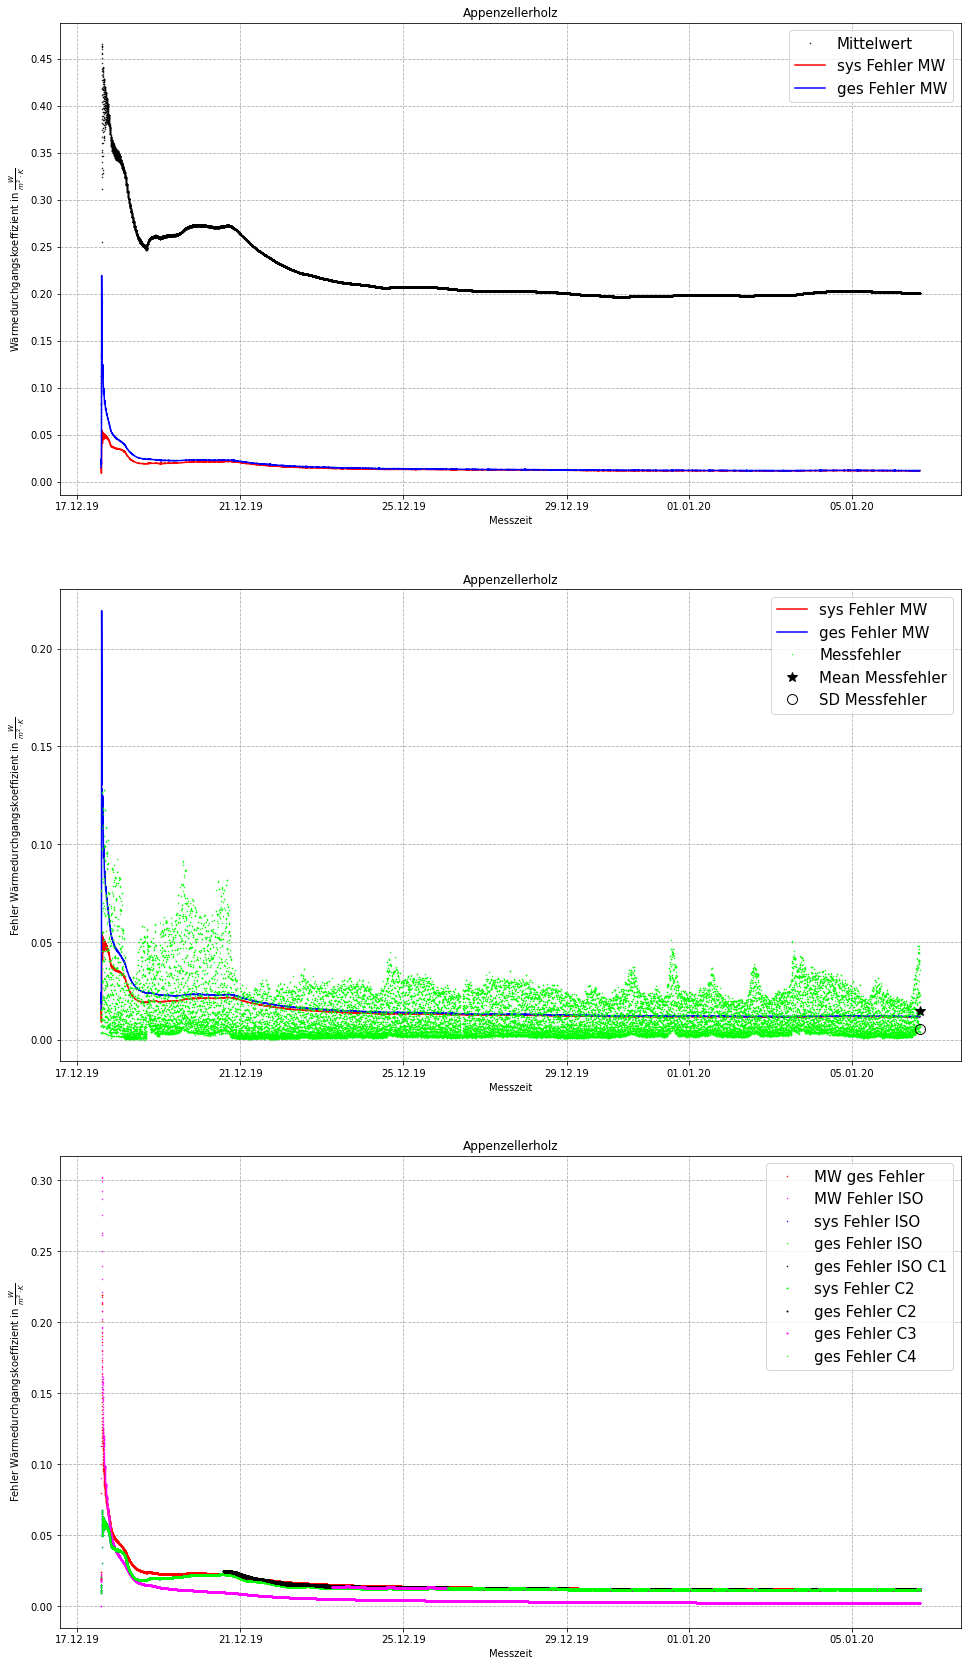

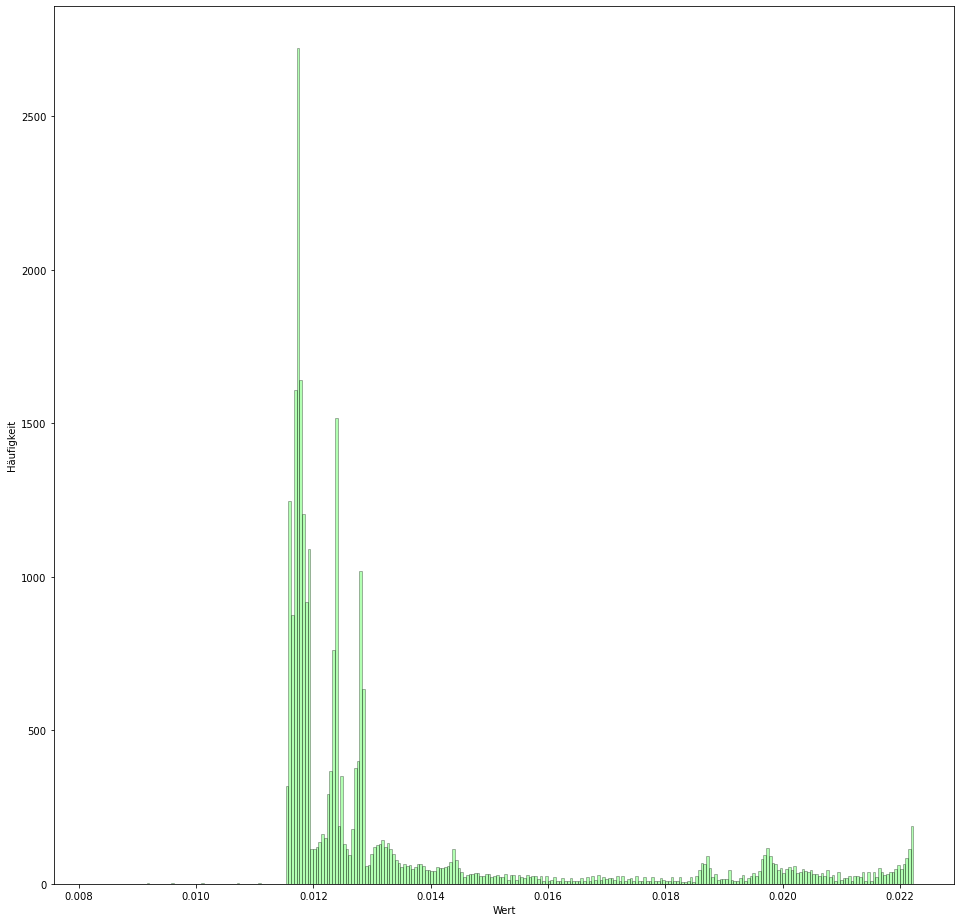

In [6]:
plot_u_values(appenzellerholz, "Appenzellerholz")

# Interaktion mit Benutzer
Hier können unsere Benutzer auswählen, von welchem Container die Daten dargestellt werden sollen:

In [4]:
from ipywidgets import interact

def myPlot(Container):
    if Container == "Appenzellerholz":
        plot_u_values(appenzellerholz, Container)
    elif Container == "Holzrahmenbau":
        plot_u_values(holzrahmenbau, Container)
    elif Container == "Massivbau":
        plot_u_values(massivbau, Container)

interact(myPlot, Container=["Appenzellerholz","Holzrahmenbau", "Massivbau"]);

interactive(children=(Dropdown(description='Container', options=('Appenzellerholz', 'Holzrahmenbau', 'Massivba…